In [14]:
import sys
sys.path.append("../")  

import numpy as np 
import torch, time
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR
import matplotlib.pyplot as plt
import utility, problem
import random
import net
from scipy.linalg import lstsq
torch.set_default_dtype(torch.float64)

def set_seed(seed=42):
    random.seed(seed)             # Python 内置随机数种子
    np.random.seed(seed)          # NumPy 随机数种子
    torch.manual_seed(seed)       # PyTorch CPU 随机数种子
    torch.cuda.manual_seed(seed)  # PyTorch GPU 随机数种子
    torch.cuda.manual_seed_all(seed)  # 多 GPU 训练时设定所有 GPU 相同种子
    torch.backends.cudnn.deterministic = True  # 保证 CUDA 计算的确定性
    torch.backends.cudnn.benchmark = False  # 关闭自动优化（可能影响速度）

plt.rcParams.update({
    'font.size': 20,
})

# 设置随机种子
set_seed(42)

In [15]:
def u_exact(x):
    return 1/2*x**2 - 1/2

def f(x):
    return -torch.ones(x.shape[0]).to(x.device)

In [16]:
def trainnew(model,problem,device,params,optimizer,scheduler):
    
    problem.generate_points(params["bodyBatch"], params["bdryBatch"], "random")
    int_data = problem.data()["interior_points"]
    bdry_data = problem.data()["boundary_points"]
    int_data.requires_grad = True
    bdry_data.requires_grad = True
    model.train()
    for step in range(params["trainStep"]):
        u = model(int_data)[1]
        u = u.squeeze(1) if len(u.shape) == 2 else u
        u_second = model(int_data)[0]
        u_bdry = model(bdry_data)[1]
        u_bdry = u_bdry.squeeze(1) if len(u_bdry.shape) == 2 else u_bdry
        model.zero_grad()
        problem.loss_int(u, int_data)
        problem.loss_bdry(u_bdry, bdry_data)
        loss_pde = problem.loss_pde()
        loss_orthogonal = torch.norm(u_second.T @ u_second - torch.eye(params["width"]).to(device).double(), p='fro')
        loss = loss_pde + loss_orthogonal*params["orthogonalpenalty"]  
        loss.backward()
        optimizer.step()
        scheduler.step()
    (A, rhs) = problem.leastsquareproblem(model, int_data, bdry_data)
    w, residuals, rank, s = lstsq(A, rhs)
    perdict = lambda x: torch.matmul(model(x)[0], torch.tensor(w).to(device))
    error_l2, error_l2_rel = problem.plot(perdict)
    return error_l2, error_l2_rel

----------------------------------------------------------
width = 10


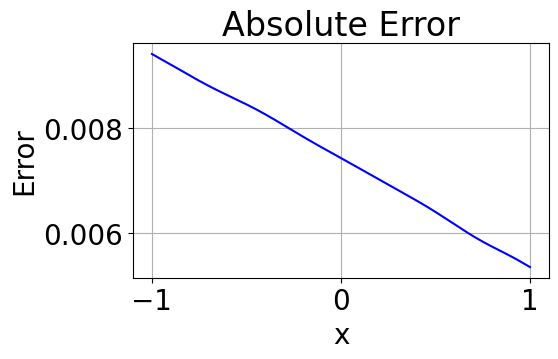

----------------------------------------------------------
width = 15


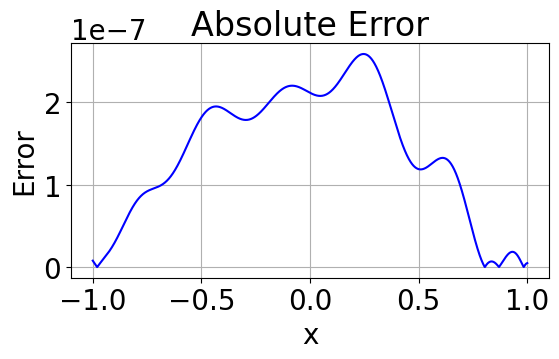

----------------------------------------------------------
width = 20


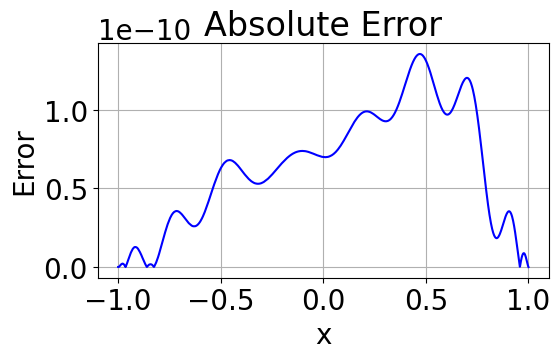

----------------------------------------------------------
width = 25


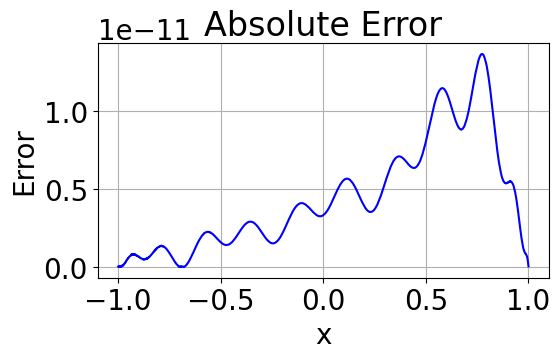

----------------------------------------------------------
width = 30


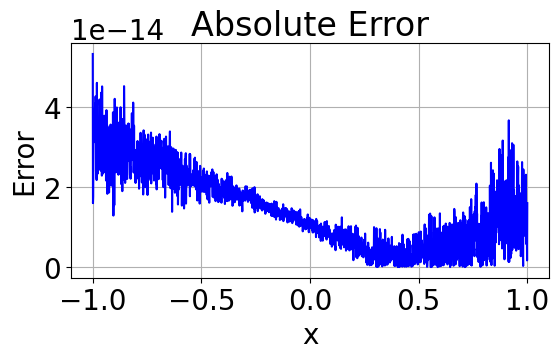

----------------------------------------------------------
width = 35


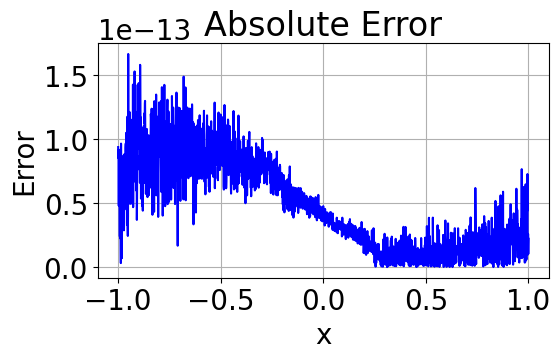

----------------------------------------------------------
width = 40


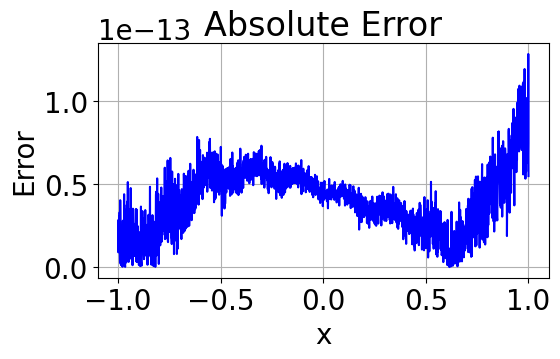

----------------------------------------------------------
width = 45


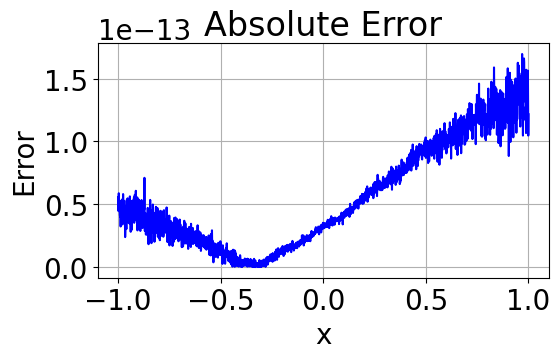

----------------------------------------------------------
width = 50


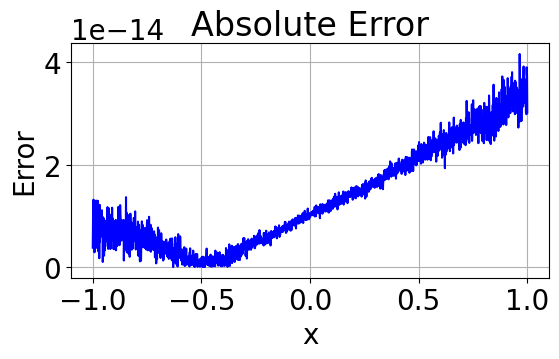

----------------------------------------------------------
width = 55


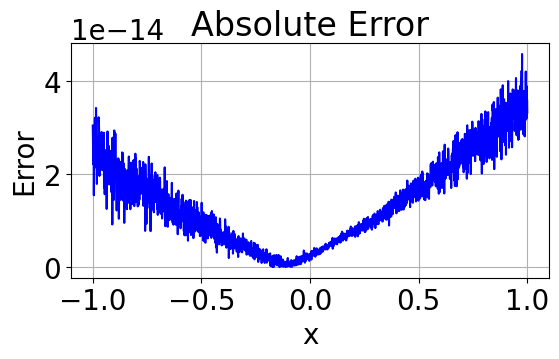

----------------------------------------------------------
width = 60


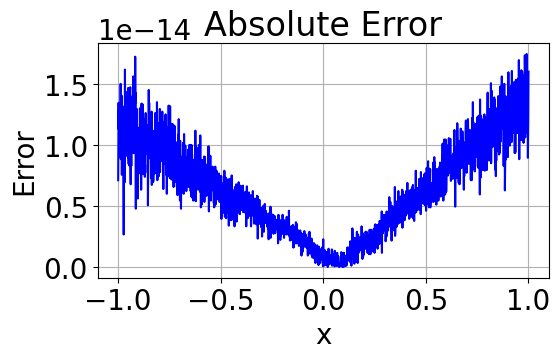

----------------------------------------------------------
width = 65


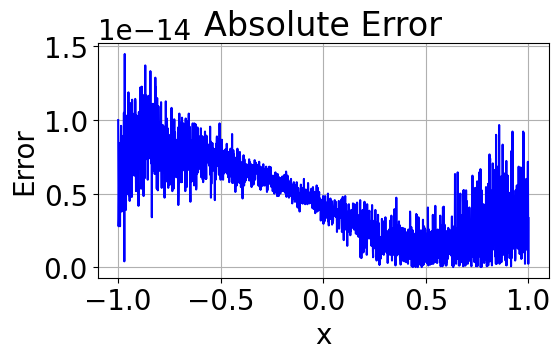

----------------------------------------------------------
width = 70


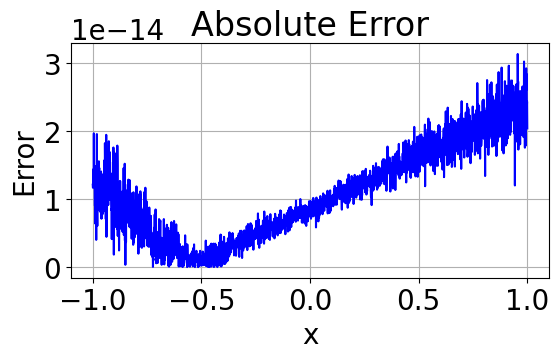

----------------------------------------------------------
width = 75


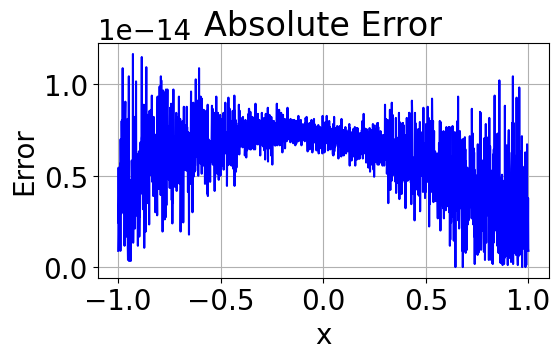

----------------------------------------------------------
width = 80


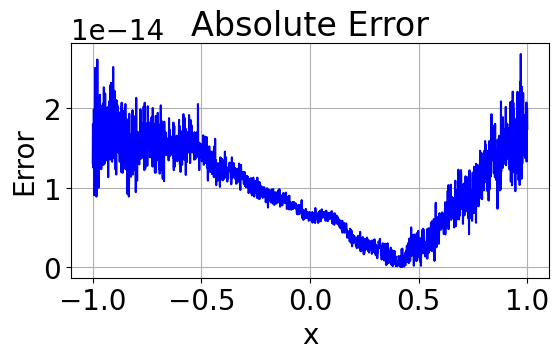

----------------------------------------------------------
width = 85


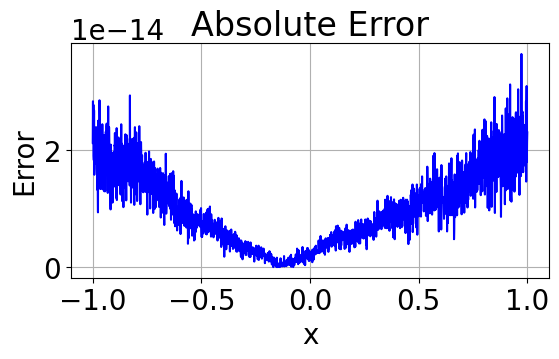

----------------------------------------------------------
width = 90


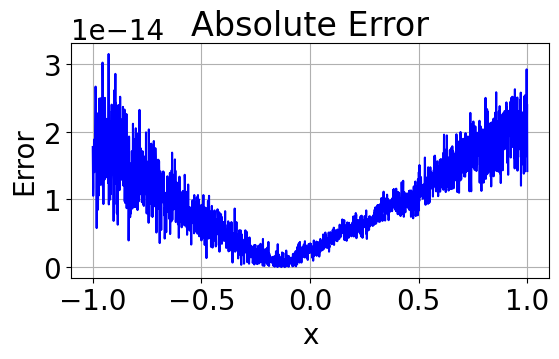

----------------------------------------------------------
width = 95


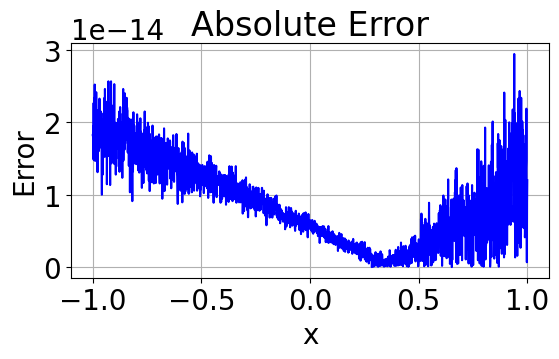

----------------------------------------------------------
width = 100


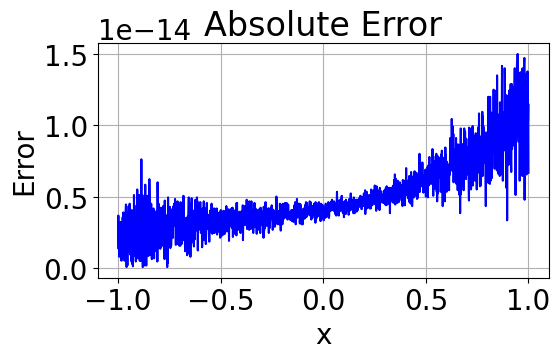

In [17]:
set_seed(42)
Pro = problem.Poisson1D(f, u_exact, u_exact, 1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
errors_rel_pdfm = []
for width in range(10, 105, 5):
    print("----------------------------------------------------------")
    print("width =", width)
    params = {"radius": 1, "d": 1, "bodyBatch": 1024, "bdryBatch": 2, "lr": 0.001, "width": width, "depth": 2, "trainStep": 100, "bdry_penalty": 1, "numberoftest": 1000, "writeStep": 5, "plotStep": 200, "sampleStep": 25, "step_size": 5000, "milestone": [], "gamma": 0.5, "decay": 0.0001, "lambda": 10, "epsilon": 1e-6, "orthogonalpenalty": 0, "beta": 1}
    params["dd"] = params["width"]
    startTime = time.time()
    model = net.PD_OFM(params).to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=params["lr"],weight_decay=params["decay"])
    scheduler = MultiStepLR(optimizer,milestones=params["milestone"],gamma=params["gamma"])
    startTime = time.time()
    error_l2, error_l2_rel = trainnew(model,Pro,device,params,optimizer,scheduler)
    errors_rel_pdfm.append(error_l2_rel)

----------------------------------------------------------
width = 10


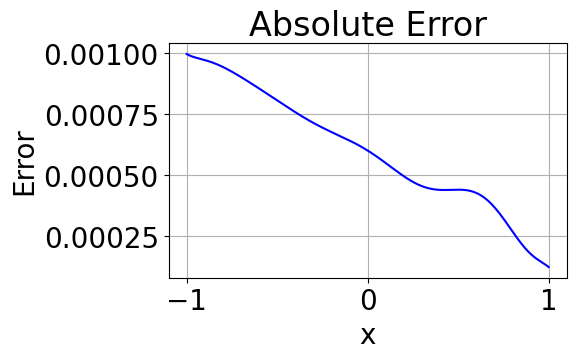

----------------------------------------------------------
width = 15


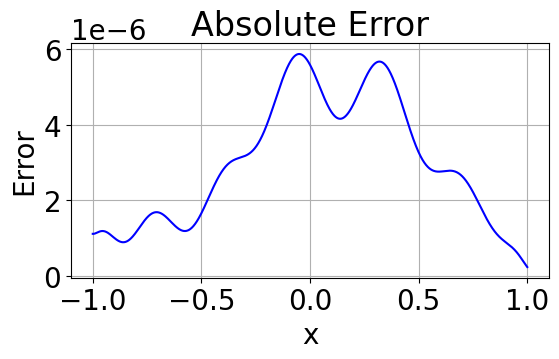

----------------------------------------------------------
width = 20


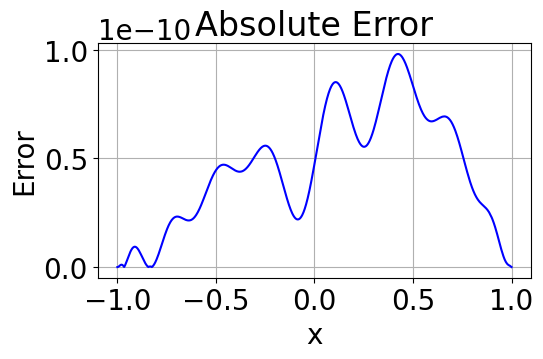

----------------------------------------------------------
width = 25


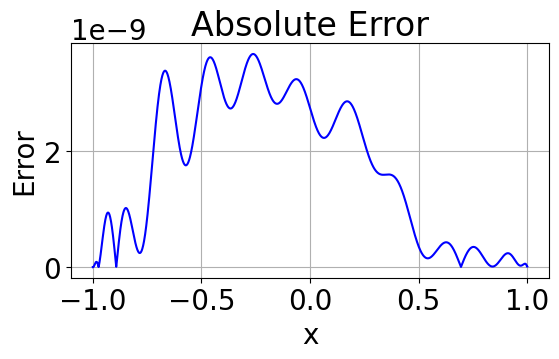

----------------------------------------------------------
width = 30


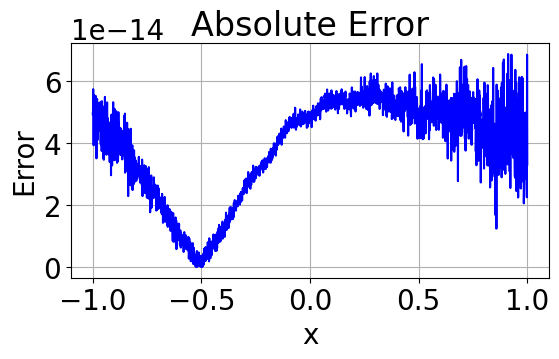

----------------------------------------------------------
width = 35


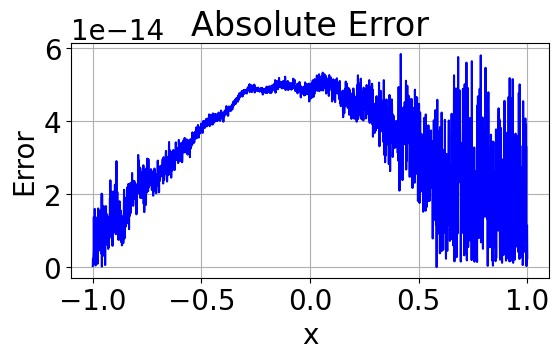

----------------------------------------------------------
width = 40


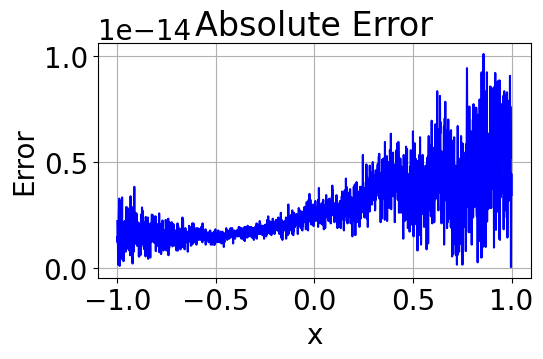

----------------------------------------------------------
width = 45


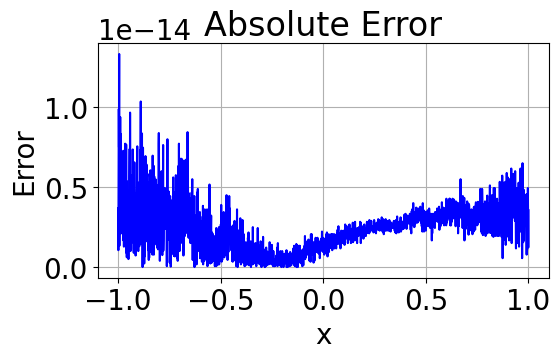

----------------------------------------------------------
width = 50


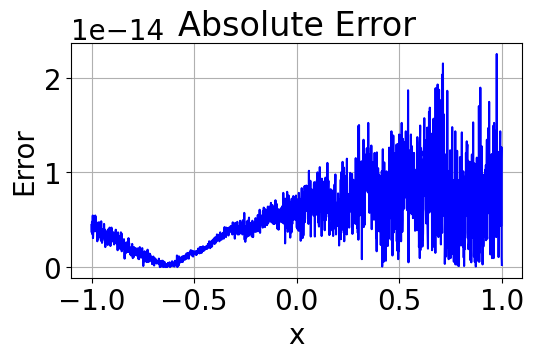

----------------------------------------------------------
width = 55


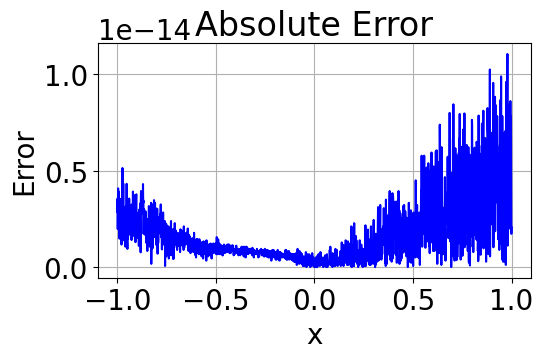

----------------------------------------------------------
width = 60


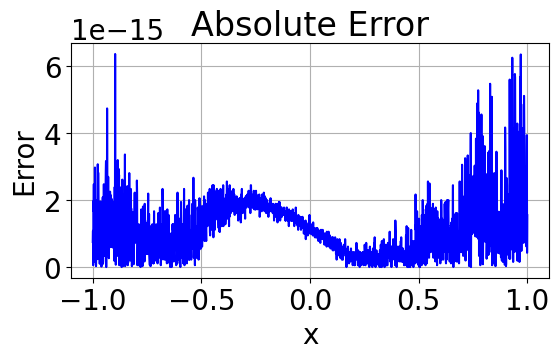

----------------------------------------------------------
width = 65


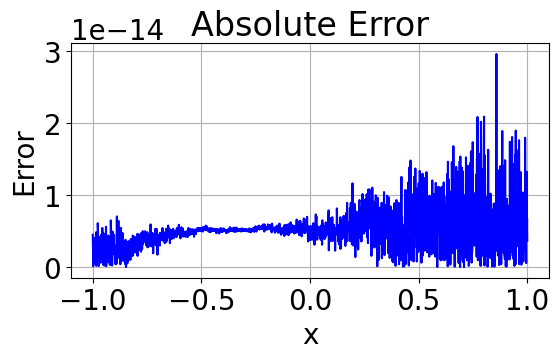

----------------------------------------------------------
width = 70


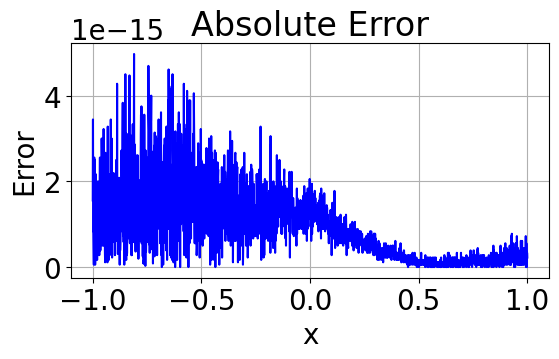

----------------------------------------------------------
width = 75


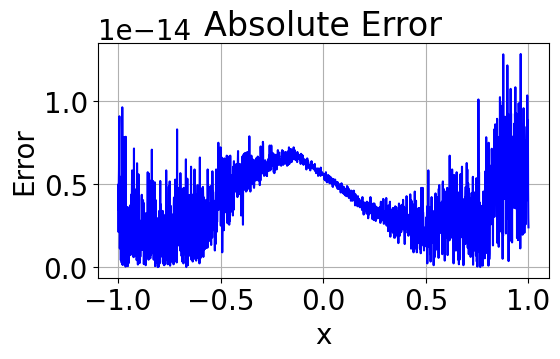

----------------------------------------------------------
width = 80


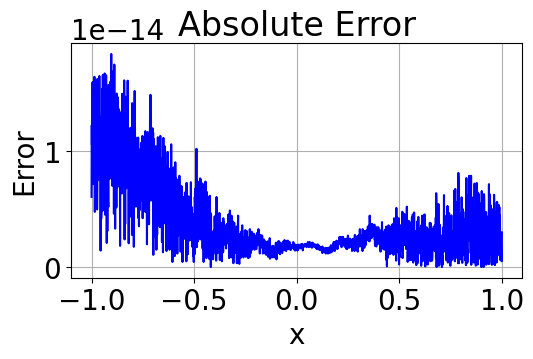

----------------------------------------------------------
width = 85


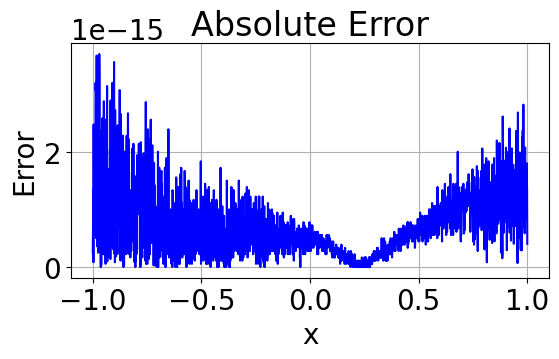

----------------------------------------------------------
width = 90


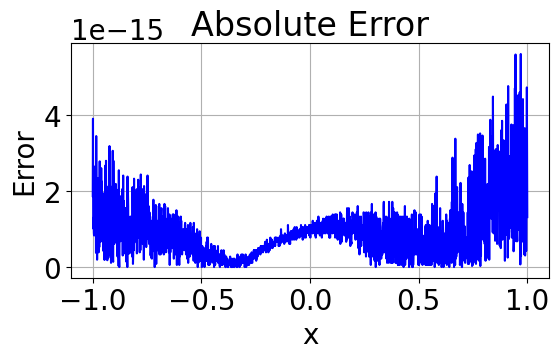

----------------------------------------------------------
width = 95


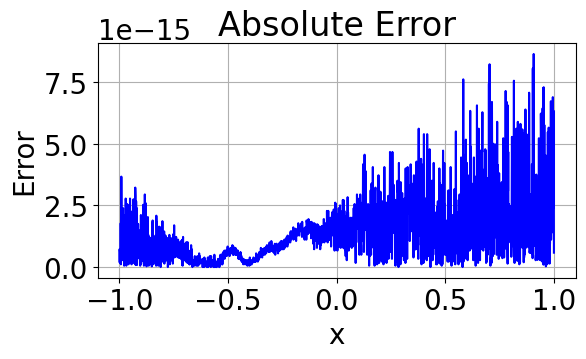

----------------------------------------------------------
width = 100


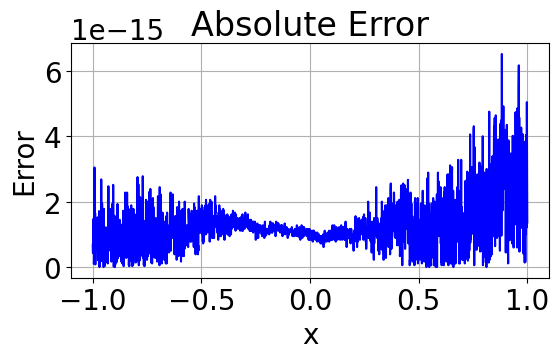

In [18]:
set_seed(42)
Pro = problem.Poisson1D(f, u_exact, u_exact, 1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
errors_rel_pdofm = []
for width in range(10, 105, 5):
    print("----------------------------------------------------------")
    print("width =", width)
    params = {"radius": 1, "d": 1, "bodyBatch": 1024, "bdryBatch": 2, "lr": 0.001, "width": width, "depth": 2, "trainStep": 100, "bdry_penalty": 1, "numberoftest": 1000, "writeStep": 5, "plotStep": 200, "sampleStep": 25, "step_size": 5000, "milestone": [], "gamma": 0.5, "decay": 0.0001, "lambda": 10, "epsilon": 1e-6, "orthogonalpenalty": 1, "beta": 1}
    params["dd"] = params["width"]
    startTime = time.time()
    model = net.PD_OFM(params).to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=params["lr"],weight_decay=params["decay"])
    scheduler = MultiStepLR(optimizer,milestones=params["milestone"],gamma=params["gamma"])
    startTime = time.time()
    error_l2, error_l2_rel = trainnew(model,Pro,device,params,optimizer,scheduler)
    errors_rel_pdofm.append(error_l2_rel)

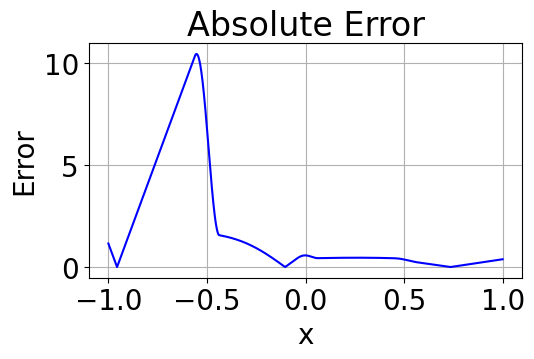

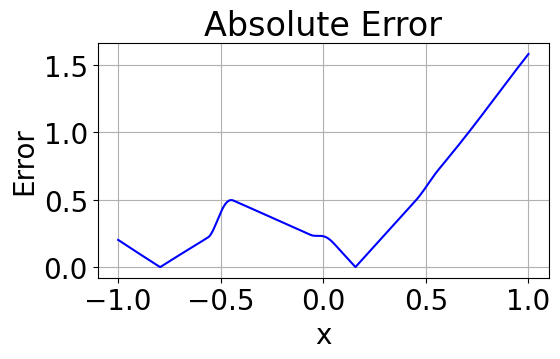

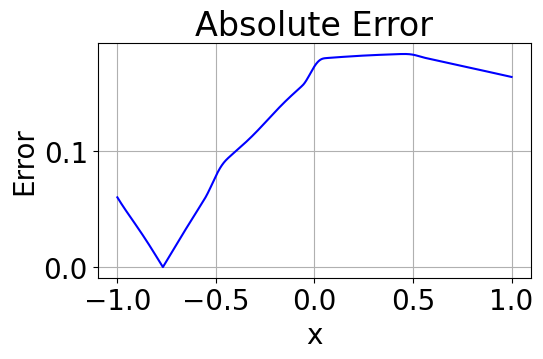

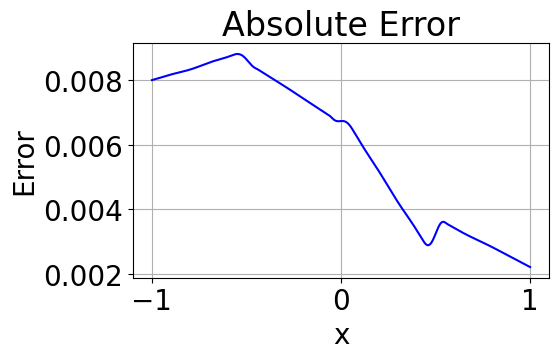

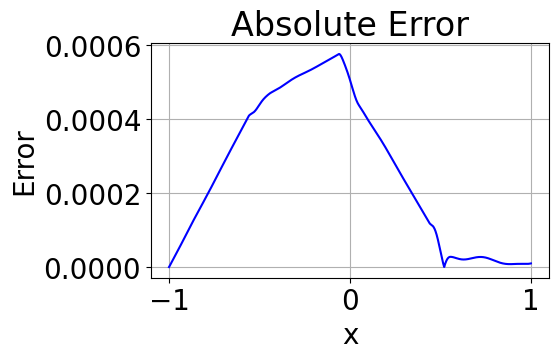

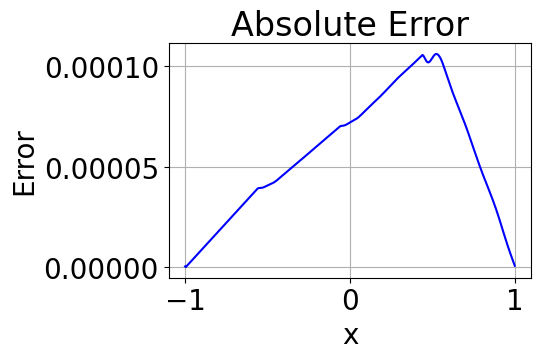

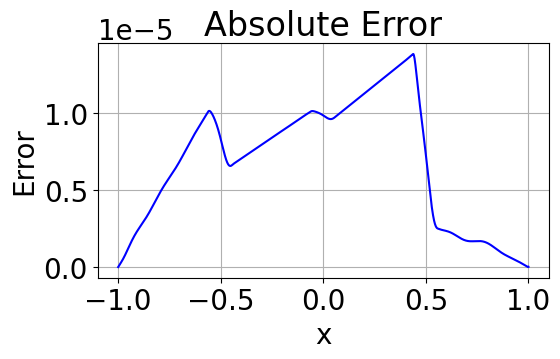

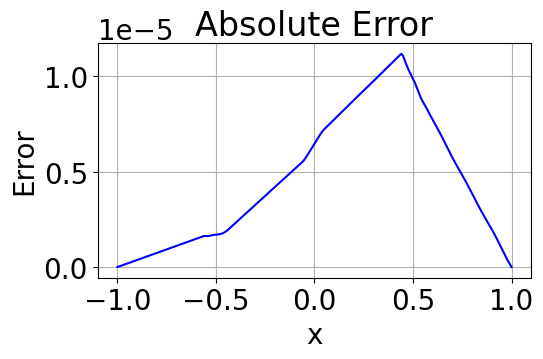

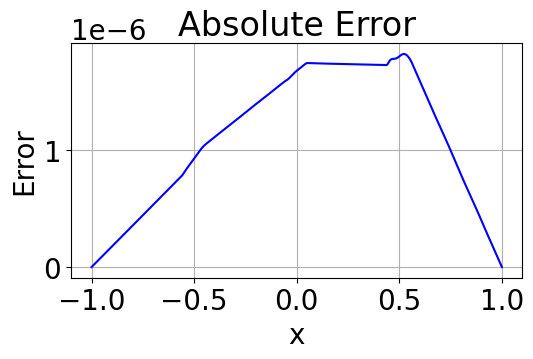

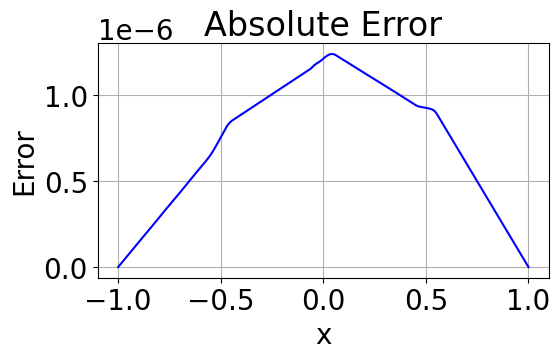

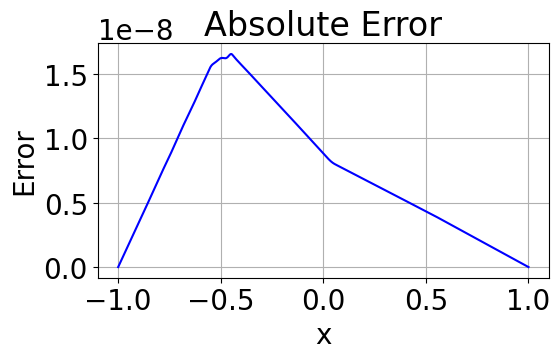

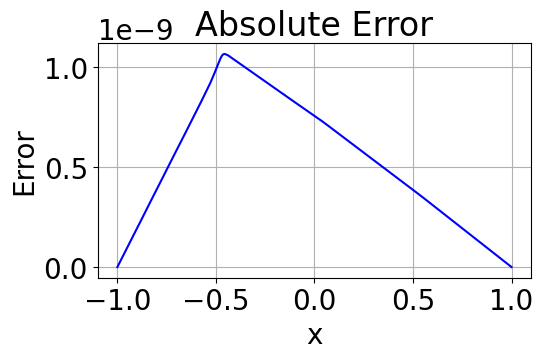

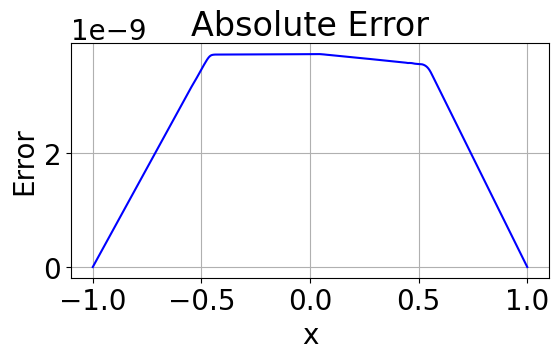

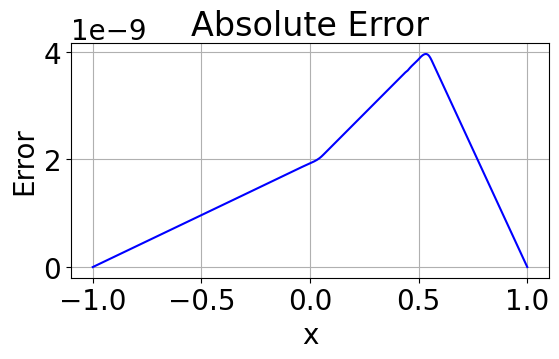

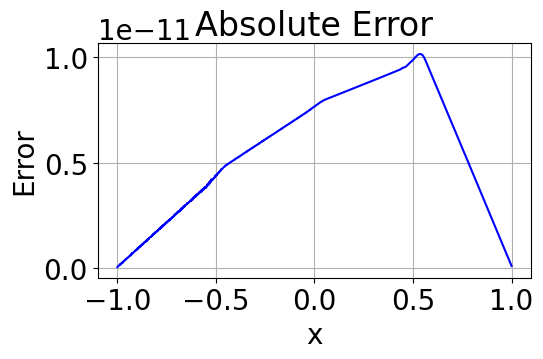

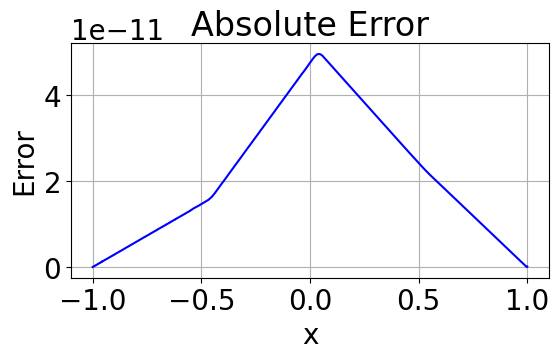

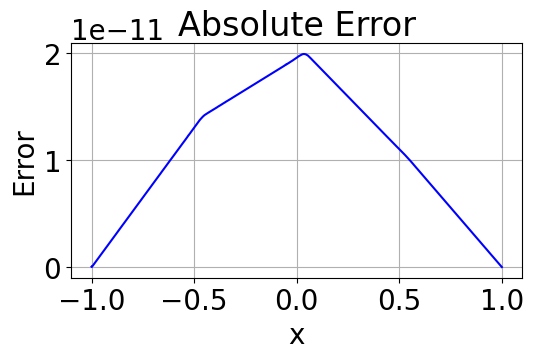

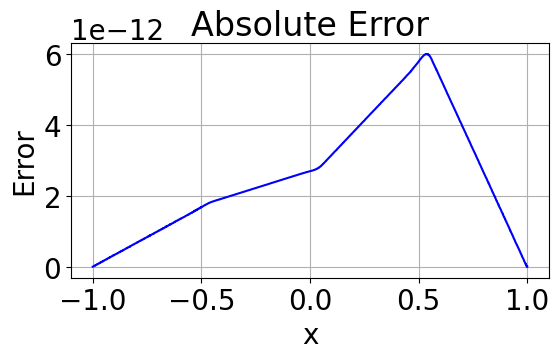

In [26]:
device="cpu"
set_seed(42)
errors_rel_rfm = []
for width in range(10, 100, 5):
    ### Initializing RFM and Problem
    params = dict()
    params = {"d": 1, "bodyBatch": 1024, "bdryBatch":128, "number_basis": width//4*4}
    centers = torch.tensor([[-0.75],[-0.25],[0.25],[0.75]], dtype=torch.float64).to(device)
    radius = torch.tensor([[0.25],[0.25],[0.25],[0.25]], dtype=torch.float64).to(device)
    model = net.RFM(params, centers, radius, typeofPoU="b", device=device).to(device)
    Pro = problem.Poisson1D(f, u_exact, u_exact, 1, device=device)
    Pro.generate_points(params["bodyBatch"], params["bdryBatch"]) 
    int_data = Pro.data()["interior_points"]
    bdry_data = Pro.data()["boundary_points"]
    int_data.requires_grad = True
    bdry_data.requires_grad = True

    ### Solving Least Sqaure Problem
    (A, rhs) = Pro.leastsquareproblem(model, int_data, bdry_data)
    w, residuals, rank, s = lstsq(A, rhs)

    ### Visualization
    perdict = lambda x: torch.matmul(model(x)[0], torch.tensor(w).to(device))
    error_l2, error_l2_rel = Pro.plot(perdict)
    errors_rel_rfm.append(error_l2_rel)

In [30]:
plt.rcParams.update({
    'font.size': 20,
})

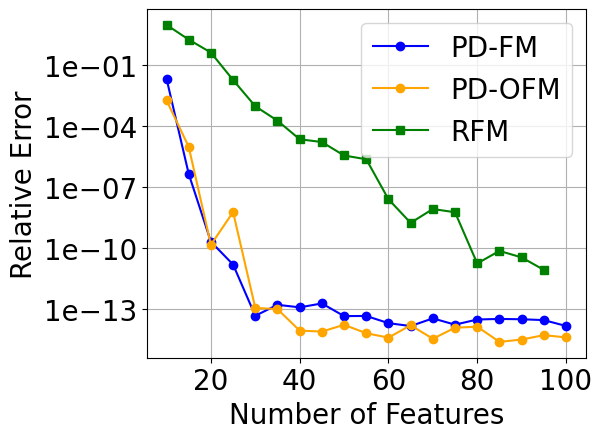

In [39]:
from matplotlib.ticker import LogLocator, LogFormatter


# Define x-axis based on the loops in previous cells
widths_pdfm = np.arange(10, 105, 5)
widths_rfm = np.arange(10, 100, 5)

plt.plot(widths_pdfm, errors_rel_pdfm, marker="o", label="PD-FM", color="blue")
plt.plot(widths_pdfm, errors_rel_pdofm, marker="o", label="PD-OFM", color="orange")
plt.plot(widths_rfm, errors_rel_rfm, marker="s", label="RFM", color="green")

# 设置对数坐标轴（以10为底）
plt.yscale('log')

# 设置稀疏的纵坐标标签 (只显示 10 的幂次)
plt.gca().yaxis.set_major_locator(LogLocator(base=10.0)) 
plt.gca().yaxis.set_major_formatter(LogFormatter(base=10.0))

# 打开次刻度线
# plt.minorticks_on()

plt.xlabel("Number of Features")
plt.ylabel("Relative Error")
plt.legend()
plt.grid(True, which="both", ls="-")
plt.tight_layout()
plt.show()